# PART 2
## Filter cells

Cells with low library size and low number of genes will be filtered out.

- **INPUT:**
    - ```$counts.RData``` 
    - ```anno_cells.RData```
    - ```anno_samples.RData```
    - ```anno_genes.RData```
    
- **NOTES:**

    The '_ctf' ending in the file names stands for cell type filter.
    
- **OUTPUT:**

    -  ```counts_cf.RData``` 
    -  ```anno_cells_cf.RData``` 
    -  ```anno_samples_cf.RData``` 
    -  ```anno_genes_cf.RData``` 

In [1]:
# paste(path_to_additional_files,tsv_file,sep="")

In [2]:
path_to_additional_files <- "../additional_input_files/"

In [3]:
path_in <- "../1.preprocess_data/outs/"
path_out <- "outs/"

In [4]:
library("ggplot2")

In [5]:
# load raw counts
load(paste0(path_in,"counts.RData"))
print(dim(counts))

[1] 19303 98936


In [6]:
# load cell annotation
load(paste0(path_in,"anno_cells.RData"))
rownames(anno_cells) <- anno_cells$cell_ID
print(str(anno_cells))

'data.frame':	87333 obs. of  14 variables:
 $ cell_ID                       : chr  "AML1012-D0_AAAAAGTTACGT" "AML1012-D0_AAAACACCAATC" "AML1012-D0_AAAATAGCCTTT" "AML1012-D0_AAACATTAAACG" ...
 $ cell_type_original            : chr  "GMP" "GMP-like" "Prog-like" "ProMono-like" ...
 $ sample_ID                     : chr  "AML1012-D0" "AML1012-D0" "AML1012-D0" "AML1012-D0" ...
 $ malignant                     : logi  FALSE TRUE TRUE TRUE TRUE TRUE ...
 $ patient_ID                    : chr  "AML1012" "AML1012" "AML1012" "AML1012" ...
 $ dataset                       : chr  "GSE116256" "GSE116256" "GSE116256" "GSE116256" ...
 $ gender                        : chr  "F" "F" "F" "F" ...
 $ age                           : int  32 32 32 32 32 32 32 32 32 32 ...
 $ health_status                 : chr  "AML" "AML" "AML" "AML" ...
 $ case_or_control               : chr  "case" "case" "case" "case" ...
 $ day                           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ cell_type                     : 

In [7]:
table(anno_cells$dataset)


GSE116256 GSE120221 
    18413     68920 

In [8]:
# load sample annotation
load(paste0(path_in,"anno_samples.RData"))
print(str(anno_samples))

'data.frame':	35 obs. of  8 variables:
 $ sample_ID      : chr  "AML1012-D0" "AML210A-D0" "AML328-D0" "AML419A-D0" ...
 $ patient_ID     : chr  "AML1012" "AML210A" "AML328" "AML419A" ...
 $ dataset        : chr  "GSE116256" "GSE116256" "GSE116256" "GSE116256" ...
 $ gender         : chr  "F" "M" "F" "F" ...
 $ age            : int  32 67 74 54 58 70 26 52 32 57 ...
 $ health_status  : chr  "AML" "AML" "AML" "AML" ...
 $ case_or_control: chr  "case" "case" "case" "case" ...
 $ day            : int  0 0 0 0 0 0 0 0 0 0 ...
NULL


In [9]:
# load gene annotation
load(paste0(path_in,"anno_genes.RData"))
print(str(anno_genes))

'data.frame':	19303 obs. of  4 variables:
 $ gene_symbol      : chr  "A1BG" "A1BG-AS1" "A1CF" "A2M" ...
 $ is_in_LR_database: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isLigand         : logi  FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ isReceptor       : logi  TRUE FALSE FALSE FALSE FALSE FALSE ...
NULL


### Process data

In [10]:
# check whether the cell IDs are the same in the counts and cell annotation files
cell_ID_overlap <- intersect(colnames(counts)
                             ,anno_cells$cell_ID)
print("str(cell_ID_overlap)")
print(str(cell_ID_overlap))

[1] "str(cell_ID_overlap)"
 chr [1:87333] "AML1012-D0_AAAAAGTTACGT" "AML1012-D0_AAAACACCAATC" ...
NULL


In [11]:
# print out cells that present in the raw counts, but not in the intersection
print(str(colnames(counts)[!(colnames(counts) %in% cell_ID_overlap)]))

 chr [1:11603] "BM-A_AAACGGGAGTTAACGA" "BM-A_AAAGCAACACTGAAGG" ...
NULL


In [12]:
# print out cells that present in the cell annotation, but not in the intersection
print(str(anno_cells$cell_ID[!(anno_cells$cell_ID %in% cell_ID_overlap)]))

 chr(0) 
NULL


### filter

In [13]:
# filter cells by their presence in the cell annotation file
counts_cf <- counts[,anno_cells$cell_ID]
print("nr cell before filtering")
print(ncol(counts))
print("nr cell after filtering")
print(ncol(counts_cf))

[1] "nr cell before filtering"
[1] 98936
[1] "nr cell after filtering"
[1] 87333


In [14]:
# calculate total counts
anno_cells$total_counts_raw <- colSums(counts_cf)
# calculate percent mito counts
print("calculate fraction of mito counts")
idx_mito_gene <- grepl("MT-", rownames(counts_cf))
anno_cells$mito_counts <- colSums(counts_cf[idx_mito_gene,])
anno_cells$frac_mito  <-  anno_cells$mito_counts / anno_cells$total_counts_raw

[1] "calculate fraction of mito counts"


In [15]:
# calculate nr genes
anno_cells$nr_genes <- colSums(counts_cf != 0)

### visualization

In [16]:
#cell filter thresholds
anno_cells$counts_upper_threshold <- 30000
anno_cells$counts_lower_threshold <- 1000
anno_cells$genes_lower_threshold <- 500
anno_cells$counts_vs_genes_threshold <- "nr_genes = 3000*log10(counts+1) - 10500"
counts_vs_genes_threshold <- function(counts
                                      ,genes){
        genes > 3000*log10(counts +1) - 10500
}

In [17]:
print(paste("counts_upper_threshold: <", anno_cells$counts_upper_threshold[1]))
print(paste("counts_lower_threshold: >",anno_cells$counts_lower_threshold[1]))
print(paste("genes_lower_threshold: >", anno_cells$genes_lower_threshold[1]))
print(paste("counts_vs_genes_threshold:",anno_cells$counts_vs_genes_threshold[1]))

[1] "counts_upper_threshold: < 30000"
[1] "counts_lower_threshold: > 1000"
[1] "genes_lower_threshold: > 500"
[1] "counts_vs_genes_threshold: nr_genes = 3000*log10(counts+1) - 10500"


In [18]:
anno_cells$counts_upper_filter <- anno_cells$total_counts_raw < anno_cells$counts_upper_threshold
anno_cells$counts_lower_filter <- anno_cells$total_counts_raw > anno_cells$counts_lower_threshold
anno_cells$genes_lower_filter <- anno_cells$nr_genes > anno_cells$genes_lower_threshold
anno_cells$counts_vs_genes_filter <- counts_vs_genes_threshold(anno_cells$total_counts_raw
                                                               ,anno_cells$nr_genes)
anno_cells$cell_filter <- anno_cells$counts_upper_filter & anno_cells$counts_lower_filter & 
        anno_cells$genes_lower_filter & anno_cells$counts_vs_genes_filter

'data.frame':	87333 obs. of  2 variables:
 $ log10_lib_size: num  3.11 3.63 3.22 3.31 3.15 ...
 $ sample_ID     : chr  "AML1012-D0" "AML1012-D0" "AML1012-D0" "AML1012-D0" ...
NULL


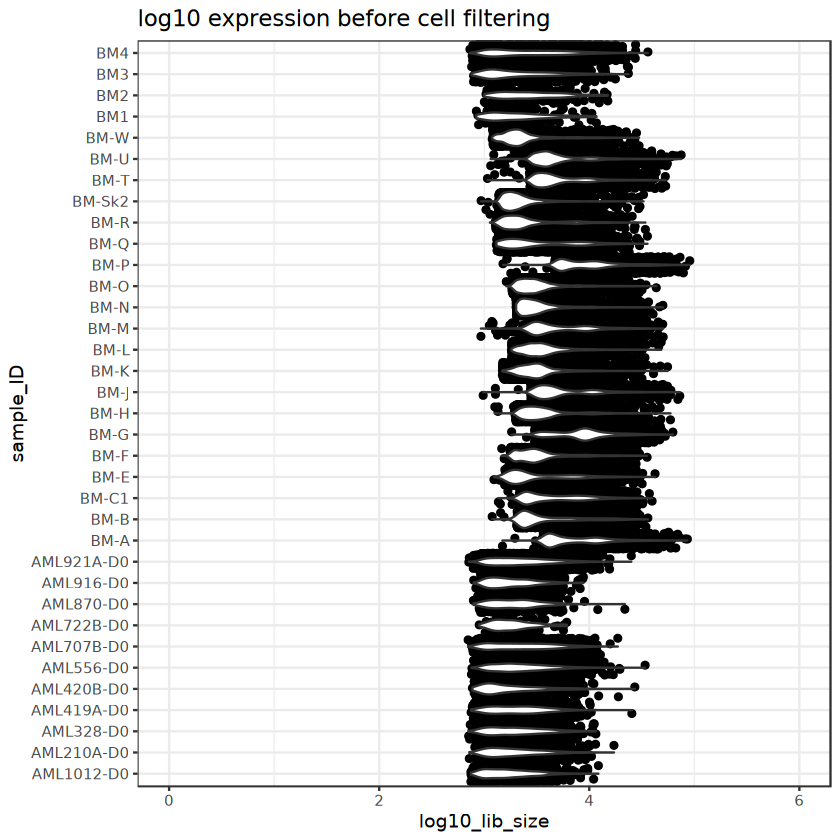

In [19]:
# visualize expression before any filtering
df <- data.frame(log10_lib_size = log10(anno_cells$total_counts_raw +1)
                 ,sample_ID = anno_cells$sample_ID
)
print(str(df))

print(ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression before cell filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()
)
rm(df)

Warning message:
“The dot-dot notation (`..level..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(level)` instead.”


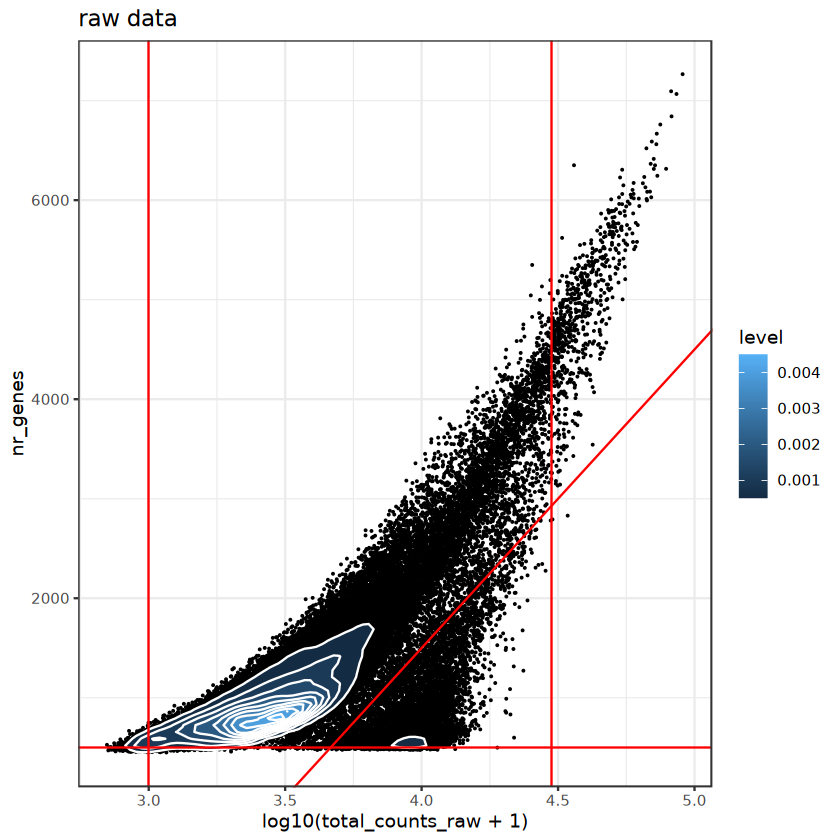

In [20]:
# plot log10 total counts vs nr genes
print(ggplot(data = anno_cells
             ,aes(x = log10(total_counts_raw +1)
                  ,y = nr_genes
             )
) +
        geom_point(size = 0.05) +
        stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
        geom_abline(intercept = -10500
                    ,slope = 3000
                    , col = "red"
        ) +
        geom_vline(xintercept = log10(c(1000,30000)+1)
                   ,col = "red") +
        geom_hline(yintercept = 500
                   ,col = "red") +
        ggtitle("raw data")+
        theme_bw()
)

In [21]:
#apply cell filters
anno_cells_cf <- anno_cells[anno_cells$cell_filter,]
print("before cell filtering:")
cat("dim(anno_cells)", dim(anno_cells),"\n")
print("after cell filtering:")
cat("dim(anno_cells_cf)", dim(anno_cells_cf),"\n")

[1] "before cell filtering:"
dim(anno_cells) 87333 27 
[1] "after cell filtering:"
dim(anno_cells_cf) 78119 27 


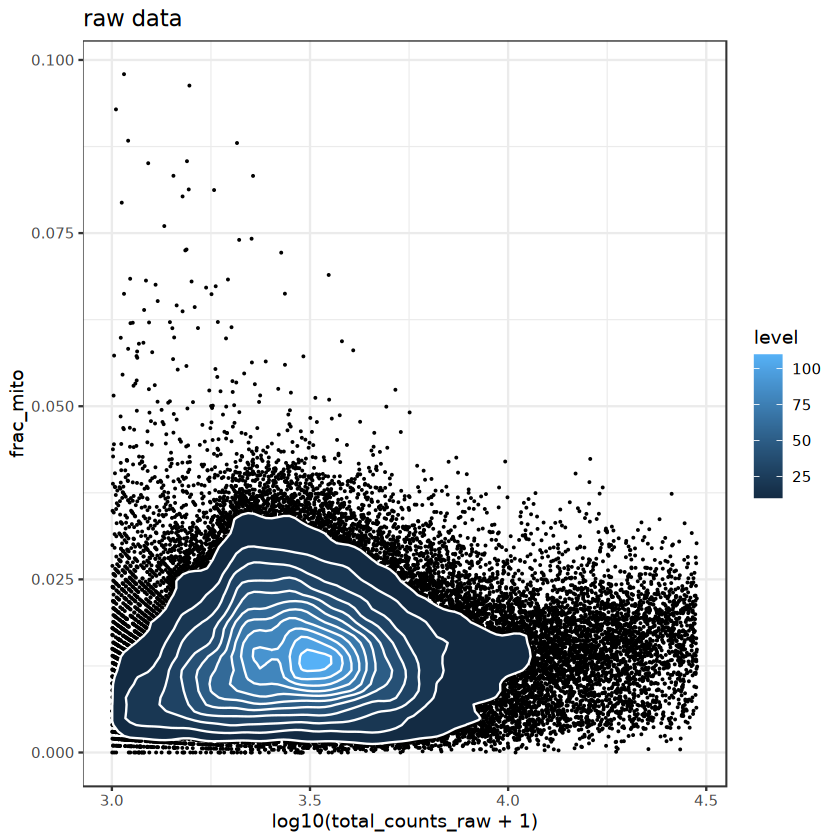

In [22]:
# plot log10 total counts vs fraction mito counts
print(ggplot(data = anno_cells_cf
             ,aes(x = log10(total_counts_raw +1)
                  ,y = frac_mito
             )
) +
        geom_point(size = 0.05) +
        stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
        ggtitle("raw data")+
        theme_bw()
)

In [23]:
# save cell number in anno_samples
for(sample in unique(anno_cells$sample_ID)){
        
        my_anno <- anno_cells[anno_cells$sample_ID == sample,]
        my_anno_cf <- anno_cells_cf[anno_cells_cf$sample_ID == sample,]
        
        anno_samples$nr_cells_raw[anno_samples$sample_ID == sample] <- nrow(my_anno)
        anno_samples$nr_cells_cf[anno_samples$sample_ID == sample] <- nrow(my_anno_cf)
}
cat("anno_samples\n\n")
print(anno_samples)

anno_samples

    sample_ID patient_ID   dataset gender age health_status case_or_control day
1  AML1012-D0    AML1012 GSE116256      F  32           AML            case   0
2  AML210A-D0    AML210A GSE116256      M  67           AML            case   0
3   AML328-D0     AML328 GSE116256      F  74           AML            case   0
4  AML419A-D0    AML419A GSE116256      F  54           AML            case   0
5  AML420B-D0    AML420B GSE116256      M  58           AML            case   0
6   AML556-D0     AML556 GSE116256      M  70           AML            case   0
7  AML707B-D0    AML707B GSE116256      M  26           AML            case   0
8  AML722B-D0    AML722B GSE116256      F  52           AML            case   0
9   AML870-D0     AML870 GSE116256      M  32           AML            case   0
10  AML916-D0     AML916 GSE116256      F  57           AML            case   0
11 AML921A-D0    AML921A GSE116256      M  42           AML            case   0
12        BM1        BM1 G

In [24]:
# subset counts
print("counts dim:")
print("before cell filtering:")
print(dim(counts_cf))
print("subset counts")
counts_cf <- counts_cf[,anno_cells_cf$cell_ID]
print("after cell filtering:")
print(dim(counts_cf))

[1] "counts dim:"
[1] "before cell filtering:"
[1] 19303 87333
[1] "subset counts"
[1] "after cell filtering:"
[1] 19303 78119


In [25]:
# visualize expression after cell filtering and before population size filtering
df <- data.frame(log10_lib_size = log10(anno_cells_cf$total_counts_raw +1)
                 ,sample_ID = anno_cells_cf$sample_ID
)
print(str(df))

'data.frame':	78119 obs. of  2 variables:
 $ log10_lib_size: num  3.11 3.63 3.22 3.31 3.15 ...
 $ sample_ID     : chr  "AML1012-D0" "AML1012-D0" "AML1012-D0" "AML1012-D0" ...
NULL


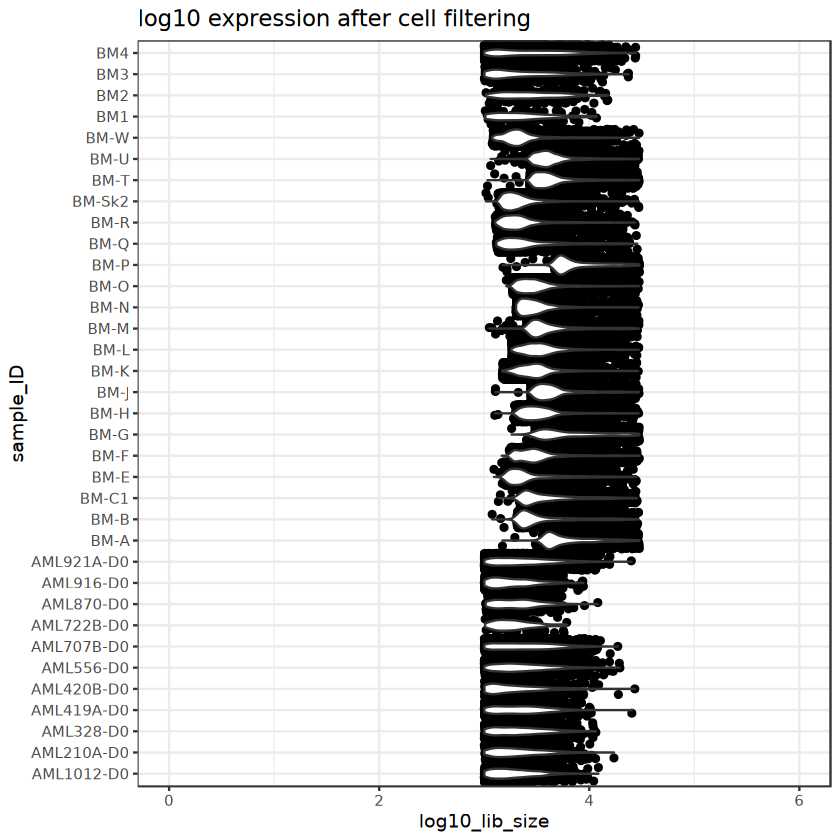

In [26]:
print(ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after cell filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()
)
rm(df)

In [27]:
anno_samples_cf <- anno_samples

anno_genes_cf <- anno_genes

### export

In [28]:
# # save counts_cf
# save(counts_cf, file = "counts_cf.RData")

# # save anno_cells_cf
# save(anno_cells_cf, file = "anno_cells_cf.RData")

# # save anno_samples_cf
# save(anno_samples_cf, file = "anno_samples_cf.RData")

# # # save anno_genes_cf
# save(anno_genes_cf, file = "anno_genes_cf.RData")

## Filter cell types

Cell types which have too few cells (less than 5 cells) per sample or are present in too few samples (less than in 30 samples) will be filtered out.

- **INPUT:**
    - ```counts_cf.RData``` 
    - ```anno_cells_cf.RData```
    - ```anno_samples_cf.RData```
    - ```anno_genes_cf.RData```
    - ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
- **NOTES:**

    The '_ctf' ending in the file names stands for cell type filter.
    
- **OUTPUT:**

    -  ```counts_cf_ctf.RData``` 
    -  ```anno_cells_cf_ctf.RData``` 
    -  ```anno_samples_cf_ctf.RData``` 
    -  ```anno_genes_cf_ctf.RData``` 

In [29]:
# load cell relabelling file
print("load cell_relabelling")

tsv_file="../..//cell_relabelling.csv"
cell_relabelling <- read.csv(file = paste(path_to_additional_files,tsv_file,sep="")
                             ,sep = ";"
                             )

cell_relabelling <- cell_relabelling[cell_relabelling$source == "van Galen et al., 2019" | cell_relabelling$source == "Oetjen et al., 2018", ]
rownames(cell_relabelling) <- cell_relabelling$cell_type_original
print(cell_relabelling)

[1] "load cell_relabelling"
                                       cell_type_original      cell_type
B                                                       B              B
CD10+ B cells                               CD10+ B cells              B
CD20+ B cells                               CD20+ B cells              B
ProB                                                 ProB              B
Mono                                                 Mono           Mono
CD14+ monocytes                           CD14+ monocytes           Mono
CD16+ monocytes                           CD16+ monocytes           Mono
Mono-like                                       Mono-like           Mono
ProMono                                           ProMono           Mono
Monocyte progenitors                 Monocyte progenitors           Mono
ProMono-like                                 ProMono-like           Mono
T                                                       T              T
CD4+ memory T cells    

In [30]:
# thresholds ####
threshold_celltype_size <- 5 # cells per celltype
print(paste("Celltype size filter: each cell type in each sample should have at least", threshold_celltype_size, "cells."))

[1] "Celltype size filter: each cell type in each sample should have at least 5 cells."


In [31]:
threshold_nr_samples <-30 # nr of samples in which a cell type should be present
print(paste("Number of samples filter: each cell type should be present in at least", threshold_nr_samples, "samples."))

[1] "Number of samples filter: each cell type should be present in at least 30 samples."


In [32]:
# color scheme for celltypes
color_celltype <- cell_relabelling$cell_type_color_hex[!duplicated(cell_relabelling$cell_type)]
names(color_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]

In [33]:
# shape scheme for celltypes
shape_celltype <- cell_relabelling$cell_type_shape[!duplicated(cell_relabelling$cell_type)]
names(shape_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]

In [34]:
# shape scheme for sample IDs
shape_sample <- c(1:11,1:24)
names(shape_sample) <- unique(anno_samples_cf$sample_ID)


In [35]:
# size scheme for sample IDs
size_sample <- c(rep(2,11),rep(1,24))
names(size_sample) <- unique(anno_samples_cf$sample_ID)

### filter


In [36]:
# store threshold values in the cell annotation file
anno_cells_cf$threshold_celltype_size <- threshold_celltype_size

In [37]:
# calculate celltype size
for(sample in unique(anno_cells_cf$sample_ID)){
        idx_sample <- anno_cells_cf$sample_ID == sample
        
        for(celltype in unique(anno_cells_cf$cell_type)){
                idx_celltype <- anno_cells_cf$cell_type == celltype
                
                idx_sample_celltype <- idx_sample & idx_celltype
                
                anno_cells_cf$celltype_size_cf[idx_sample_celltype] <- nrow(anno_cells_cf[idx_sample_celltype,])
        }
}

In [38]:
# calculate celltype size filter
anno_cells_cf$celltype_size_filter <- anno_cells_cf$celltype_size_cf >= anno_cells_cf$threshold_celltype_size

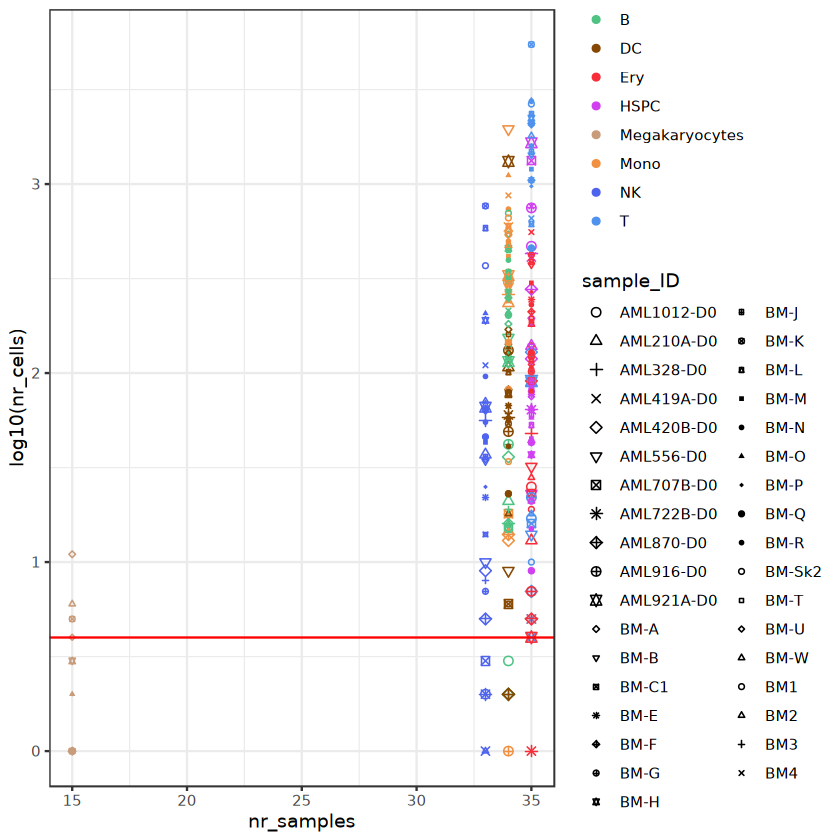

In [39]:
# visualize nr_samples vs log10_nr_cells before filtering
df <-unique(data.frame(sample_ID = anno_cells_cf$sample_ID
                       ,cell_type = anno_cells_cf$cell_type
                )
            )
df$nr_cells <- sapply(1: nrow(df)
                      ,function(i){
                              my_sample <- df$sample_ID[i]
                              my_celltype <- df$cell_type[i]
                              nr_cells <- sum((anno_cells_cf$sample_ID == my_sample) & (anno_cells_cf$cell_type == my_celltype))
                              nr_cells
                      })
df$nr_samples <- sapply(1: nrow(df)
                        ,function(i){
                                my_celltype <- df$cell_type[i]
                                idx_celltype <- anno_cells_cf$cell_type == my_celltype
                                nr_samples <- length(unique(anno_cells_cf$sample_ID[idx_celltype]))
                                nr_samples
                        })

ggplot(data = df
       ,aes(x=nr_samples
            ,y=log10(nr_cells)
            ,color=cell_type
            ,shape=sample_ID
            ,size = sample_ID
            )
       )+
        geom_point()+
        scale_color_manual(values=color_celltype)+
        scale_shape_manual(values=shape_sample)+
        scale_size_manual(values=size_sample)+
        geom_hline(yintercept = log10(threshold_celltype_size)-0.1
                   ,color = "red")+
        theme_bw()

In [40]:
# apply celltype size filter
# filter cell annotation file
anno_cells_cf_ctf <- anno_cells_cf[anno_cells_cf$celltype_size_filter,]
print("number of cells before celltype size filtering:")
print(nrow(anno_cells_cf))
print("number of cells after celltype size filtering:")
print(nrow(anno_cells_cf_ctf))

[1] "number of cells before celltype size filtering:"
[1] 78119
[1] "number of cells after celltype size filtering:"
[1] 78072


In [41]:
# filer count matrix
counts_cf_ctf <- counts_cf[,anno_cells_cf$celltype_size_filter]
rm(counts_cf)

In [42]:
print("following cell types didn't pass the celltype size filter:")
for(sample in unique(anno_cells_cf_ctf$sample_ID)){
        print(sample)
        my_anno_cf <- anno_cells_cf[anno_cells_cf$sample_ID == sample,]
        print(table(my_anno_cf[!my_anno_cf$celltype_size_filter,"cell_type"]))
}

[1] "following cell types didn't pass the celltype size filter:"
[1] "AML1012-D0"

 B NK 
 3  2 
[1] "AML210A-D0"
< table of extent 0 >
[1] "AML328-D0"
< table of extent 0 >
[1] "AML419A-D0"

NK  T 
 1  4 
[1] "AML420B-D0"

DC 
 2 
[1] "AML556-D0"
< table of extent 0 >
[1] "AML707B-D0"

NK 
 3 
[1] "AML722B-D0"

Ery  NK 
  1   2 
[1] "AML870-D0"

 B DC 
 2  2 
[1] "AML916-D0"

Mono 
   1 
[1] "AML921A-D0"

Ery 
  4 
[1] "BM1"
< table of extent 0 >
[1] "BM2"

NK 
 1 
[1] "BM3"
< table of extent 0 >
[1] "BM4"
< table of extent 0 >
[1] "BM-A"
< table of extent 0 >
[1] "BM-B"

Megakaryocytes 
             1 
[1] "BM-C1"

Megakaryocytes 
             1 
[1] "BM-E"

Megakaryocytes 
             1 
[1] "BM-F"

Megakaryocytes 
             1 
[1] "BM-G"

Megakaryocytes 
             1 
[1] "BM-H"

Megakaryocytes 
             3 
[1] "BM-J"
< table of extent 0 >
[1] "BM-K"
< table of extent 0 >
[1] "BM-L"
< table of extent 0 >
[1] "BM-M"
< table of extent 0 >
[1] "BM-N"

Megakaryocytes 
       

### filter for being present in the minimun number of samples

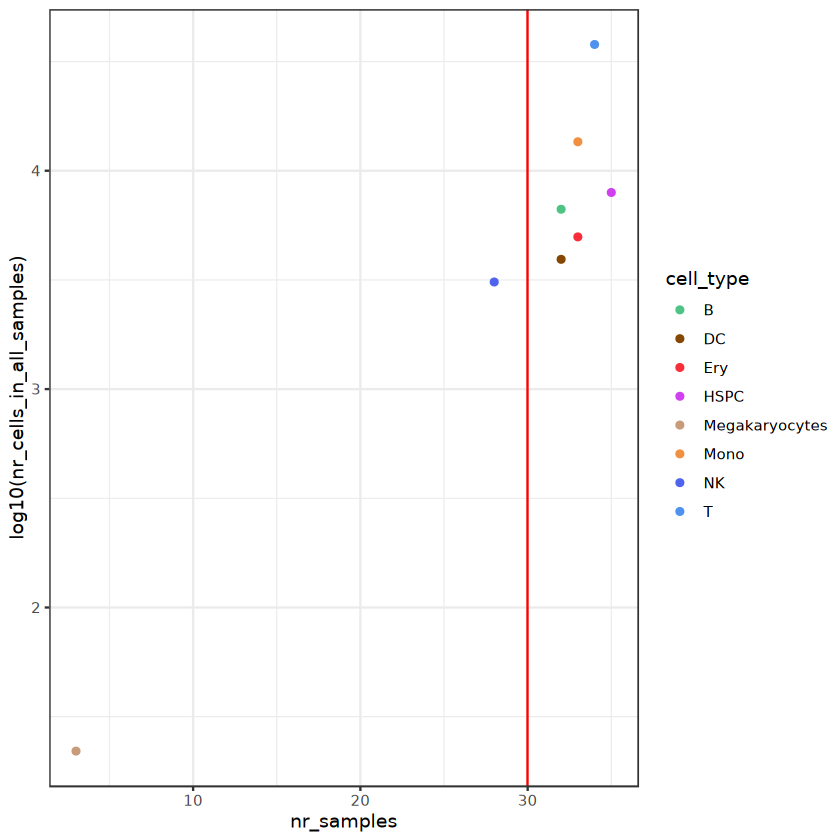

In [43]:
# visualize nr_samples vs log10_nr_cells_all_samples before filtering
df <-unique(data.frame(cell_type = anno_cells_cf_ctf$cell_type))

df$nr_cells_in_all_samples <- sapply(1: nrow(df)
                      ,function(i){
                              my_celltype <- df$cell_type[i]
                              nr_cells <- sum(anno_cells_cf_ctf$cell_type == my_celltype)
                              nr_cells
                      })

df$nr_samples <- sapply(1: nrow(df)
                        ,function(i){
                                my_celltype <- df$cell_type[i]
                                idx_celltype <- anno_cells_cf_ctf$cell_type == my_celltype
                                nr_samples <- length(unique(anno_cells_cf_ctf$sample_ID[idx_celltype]))
                                nr_samples
                        })

rownames(df) <- df$cell_type

ggplot(data = df
       ,aes(x = nr_samples
            ,y = log10(nr_cells_in_all_samples)
            ,color = cell_type
       )
) +
        geom_point() +
        scale_color_manual(values = color_celltype) +
        geom_vline(xintercept = threshold_nr_samples
                   ,color = "red")+
        theme_bw()

### filter out underrepresented cell types

In [44]:
print(paste("filter out celltypes present in less than"
             ,threshold_nr_samples
             ,"samples"))
print("following celltypes didn' pass the filter")
bad_celltypes <- rownames(df)[df$nr_samples < threshold_nr_samples]
print(bad_celltypes)

[1] "filter out celltypes present in less than 30 samples"
[1] "following celltypes didn' pass the filter"
[1] "NK"             "Megakaryocytes"


In [45]:
print("dim(counts_cf_ctf) before filtering")
print(dim(counts_cf_ctf))
counts_cf_ctf <- counts_cf_ctf[,!(anno_cells_cf_ctf$cell_type %in% bad_celltypes)]
print("dim(counts_cf_ctf) after filtering")
print(dim(counts_cf_ctf))
print("dim(anno_cells_cf_ctf) before filtering")
print(dim(anno_cells_cf_ctf))
anno_cells_cf_ctf <- anno_cells_cf_ctf[!(anno_cells_cf_ctf$cell_type %in% bad_celltypes),]
print("dim(anno_cells_cf_ctf) after filtering")
print(dim(anno_cells_cf_ctf))

[1] "dim(counts_cf_ctf) before filtering"
[1] 19303 78072
[1] "dim(counts_cf_ctf) after filtering"
[1] 19303 74956
[1] "dim(anno_cells_cf_ctf) before filtering"
[1] 78072    30
[1] "dim(anno_cells_cf_ctf) after filtering"
[1] 74956    30


In [46]:
# visualize expression after cell filtering and celltype size filtering
print("visualize expression after cell filtering and celltype size filtering")
df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf$total_counts_raw +1)
                 ,sample_ID = anno_cells_cf_ctf$sample_ID
)
print(str(df))

[1] "visualize expression after cell filtering and celltype size filtering"
'data.frame':	74956 obs. of  2 variables:
 $ log10_lib_size: num  3.11 3.63 3.22 3.31 3.15 ...
 $ sample_ID     : chr  "AML1012-D0" "AML1012-D0" "AML1012-D0" "AML1012-D0" ...
NULL


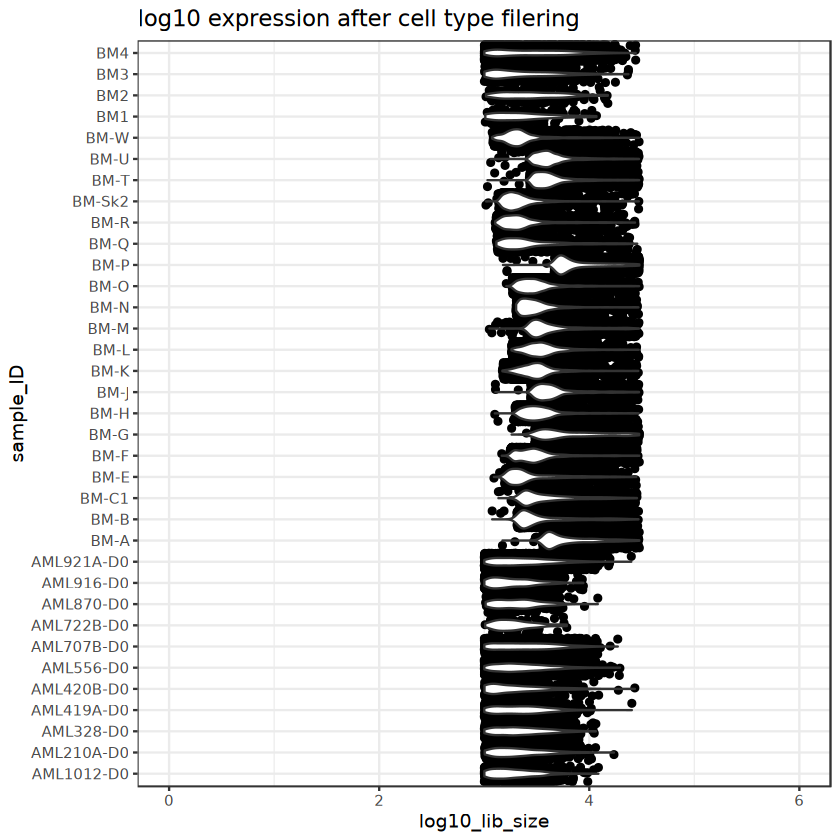

In [47]:
ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after cell type filering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

In [48]:
# create anno_samples_cf_ctf
anno_samples_cf_ctf <- anno_samples_cf

In [49]:
# save cell number in anno_samples
for(sample in unique(anno_cells_cf_ctf$sample_ID)){
        
        my_anno_cf <- anno_cells_cf_ctf[anno_cells_cf_ctf$sample_ID == sample,]
        
        anno_samples_cf_ctf$nr_cells_cf_ctf[anno_samples_cf_ctf$sample_ID == sample] <- nrow(my_anno_cf)
}
print("anno_samples_cf_ctf")
print(anno_samples_cf_ctf)

[1] "anno_samples_cf_ctf"
    sample_ID patient_ID   dataset gender age health_status case_or_control day
1  AML1012-D0    AML1012 GSE116256      F  32           AML            case   0
2  AML210A-D0    AML210A GSE116256      M  67           AML            case   0
3   AML328-D0     AML328 GSE116256      F  74           AML            case   0
4  AML419A-D0    AML419A GSE116256      F  54           AML            case   0
5  AML420B-D0    AML420B GSE116256      M  58           AML            case   0
6   AML556-D0     AML556 GSE116256      M  70           AML            case   0
7  AML707B-D0    AML707B GSE116256      M  26           AML            case   0
8  AML722B-D0    AML722B GSE116256      F  52           AML            case   0
9   AML870-D0     AML870 GSE116256      M  32           AML            case   0
10  AML916-D0     AML916 GSE116256      F  57           AML            case   0
11 AML921A-D0    AML921A GSE116256      M  42           AML            case   0
12        BM1 

In [50]:
# create anno_gene_cf_ctf
anno_genes_cf_ctf <- anno_genes_cf

### export

In [51]:
# #save counts_cf_ctf.RData
# save(counts_cf_ctf, file = "counts_cf_ctf.RData")

# #save anno_cells_cf_ctf.RData
# save(anno_cells_cf_ctf, file = "anno_cells_cf_ctf.RData")

# #save anno_samples_cf_ctf.RData
# save(anno_samples_cf_ctf, file = "anno_samples_cf_ctf.RData")

# #save anno_genes_cf_ctf.RData
# save(anno_genes_cf_ctf, file = "anno_genes_cf_ctf.RData")

## Filter genes

Individual genes might be specific to certain cell types in certain health conditions. Here we will construct pseudo-bulk cell types (per sample) and filter out genes that have too low cumulative expression in these pseudo-bulks.

- **INPUT:**
    - ```counts_cf_ctf.RData``` 
    - ```anno_cells_cf_ctf.RData```
    - ```anno_samples_cf_ctf.RData```
    - ```anno_genes_cf_ctf.RData```
    - ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
- **NOTES:**

    The '_gf' ending in the file names stands for gene filter.
    
- **OUTPUT:**

    -  ```counts_cf_ctf_gf.RData```
    -  ```anno_cells_cf_ctf_gf.RData```
    -  ```anno_samples_cf_ctf_gf.RData```
    -  ```anno_genes_cf_ctf_gf.RData```

In [52]:
rownames(cell_relabelling) <- cell_relabelling$cell_type_original
print(str(cell_relabelling))

'data.frame':	40 obs. of  9 variables:
 $ cell_type_original    : chr  "B" "CD10+ B cells" "CD20+ B cells" "ProB" ...
 $ cell_type             : chr  "B" "B" "B" "B" ...
 $ source                : chr  "van Galen et al., 2019" "Oetjen et al., 2018" "Oetjen et al., 2018" "van Galen et al., 2019" ...
 $ cell_type_color       : chr  "green" "green" "green" "green" ...
 $ cell_type_color_hex   : chr  "#4FC384" "#4FC384" "#4FC384" "#4FC384" ...
 $ cell_type_shape       : int  12 12 12 12 13 13 13 13 13 13 ...
 $ cell_subtype          : chr  "B" "B" "B" "B" ...
 $ cell_subtype_color    : chr  "green" "green" "green" "green" ...
 $ cell_subtype_color_hex: chr  "#4FC384" "#4FC384" "#4FC384" "#4FC384" ...
NULL


In [53]:
# thresholds
threshold_sum_pseudobulkCellType_expr <- 1
print(paste("threshold_sum_pseudobulkCellType_expr: >", threshold_sum_pseudobulkCellType_expr))

[1] "threshold_sum_pseudobulkCellType_expr: > 1"


In [54]:
# color scheme for celltypes
color_celltype <- cell_relabelling$cell_type_color_hex[!duplicated(cell_relabelling$cell_type)]
names(color_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]

### process data

In [55]:
# construct pseudo sorted bulk

anno_cells_cf_ctf$cell_type_ID <- paste(anno_cells_cf_ctf$cell_type
                                        ,anno_cells_cf_ctf$sample_ID
                                        ,sep = "_"
)

In [56]:
cell_type_IDs <- unique(anno_cells_cf_ctf$cell_type_ID)
counts_raw_pseudobulkCellType <- as.data.frame(matrix(,nrow = nrow(counts_cf_ctf)
                                                    ,ncol = length(cell_type_IDs)
))

i <- 1
for(cell_type_ID in cell_type_IDs){
        #print(cell_type_ID)
        
        idx_cell_type_ID <- anno_cells_cf_ctf$cell_type_ID == cell_type_ID
        
        if(sum(idx_cell_type_ID) == 0){
                counts_raw_pseudobulkCellType[,i] <- 0
        } else if( sum(idx_cell_type_ID) == 1){
                counts_raw_pseudobulkCellType[,i] <- counts_cf_ctf[,idx_cell_type_ID]
        } else {
                counts_raw_pseudobulkCellType[,i] <- rowMeans(counts_cf_ctf[,idx_cell_type_ID])
        }
        
        i <- i+1
}

colnames(counts_raw_pseudobulkCellType) <- cell_type_IDs
rownames(counts_raw_pseudobulkCellType) <- rownames(counts_cf_ctf)
cat("str(counts_raw_pseudobulkCellType\n\n)")
print(str(counts_raw_pseudobulkCellType))

str(counts_raw_pseudobulkCellType

)'data.frame':	19303 obs. of  199 variables:
 $ HSPC_AML1012-D0: num  0.0554 0 0 0 0 ...
 $ Mono_AML1012-D0: num  0.1221 0 0 0.0033 0.0033 ...
 $ DC_AML1012-D0  : num  0.053 0 0 0 0 ...
 $ Ery_AML1012-D0 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ T_AML1012-D0   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ B_AML210A-D0   : num  0.0476 0 0 0 0 ...
 $ Mono_AML210A-D0: num  0.06838 0 0 0.00427 0.00855 ...
 $ DC_AML210A-D0  : num  0.0748 0 0 0 0 ...
 $ Ery_AML210A-D0 : num  0.0769 0 0 0 0 ...
 $ HSPC_AML210A-D0: num  0.0863 0 0 0.0144 0.0288 ...
 $ T_AML210A-D0   : num  0.0787 0 0 0.0112 0 ...
 $ HSPC_AML328-D0 : num  0.17633 0.00232 0.00232 0.02552 0.03016 ...
 $ T_AML328-D0    : num  0.0825 0 0 0.0309 0 ...
 $ Mono_AML328-D0 : num  0.08494 0 0 0.00386 0.00772 ...
 $ DC_AML328-D0   : num  0.1724 0.0172 0 0 0.0172 ...
 $ Ery_AML328-D0  : num  0.0208 0 0 0 0.0208 ...
 $ B_AML328-D0    : num  0.125 0 0 0 0 0 0 0 0 0 ...
 $ Mono_AML419A-D0: num  0.13828 0.00843 0.00169 0 0.00675

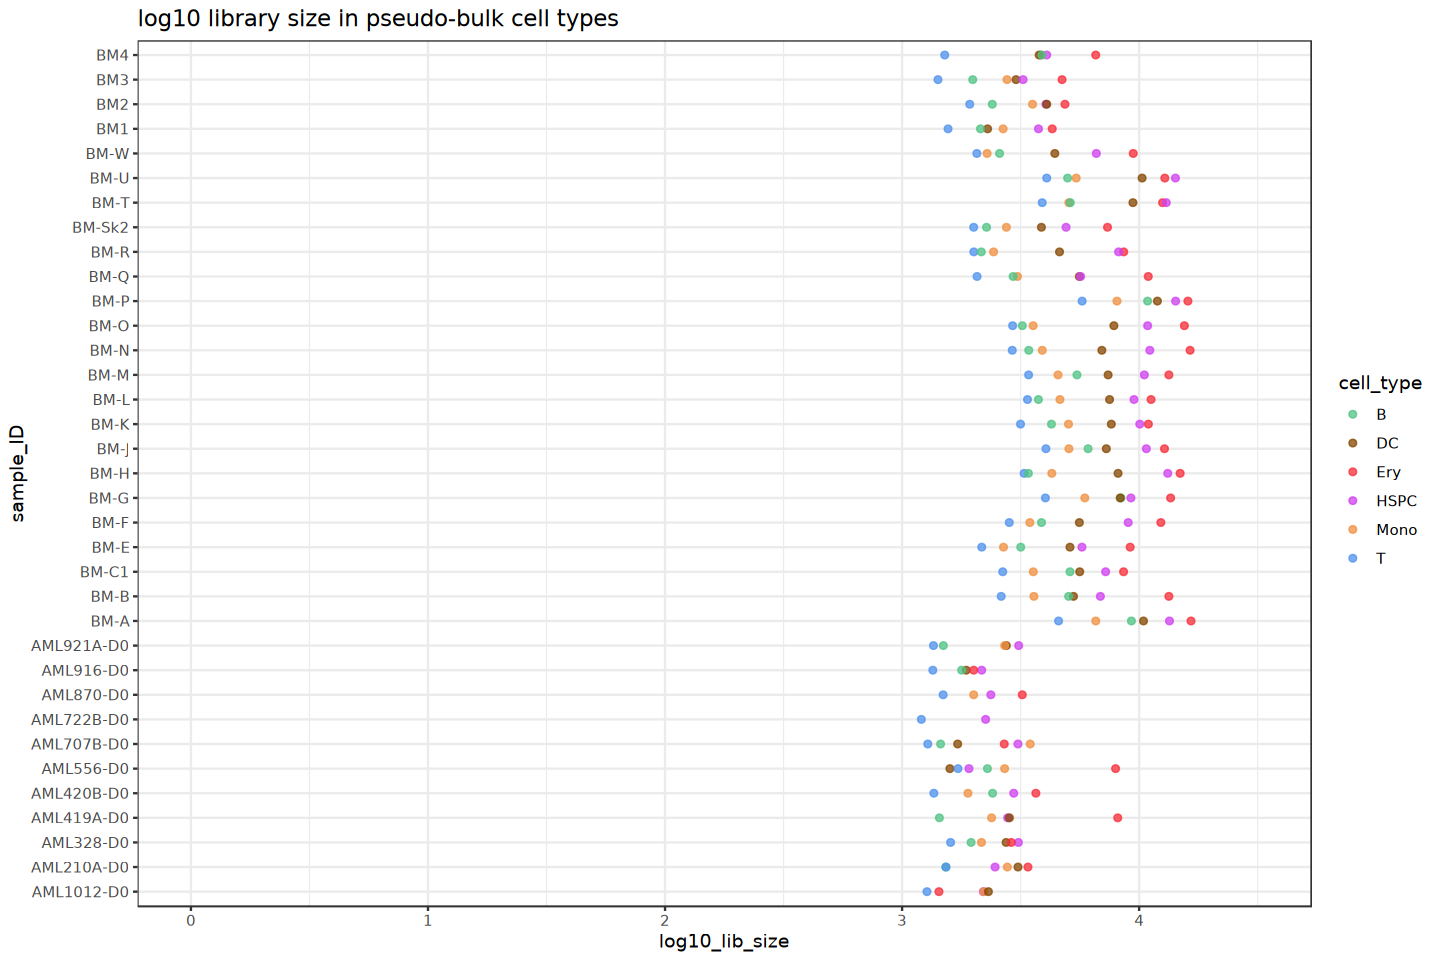

In [57]:
# visualize expression in pseudo sorted bulk
options(repr.plot.width=12, repr.plot.height=8) # plot margins

my_sampes <- sub("_.*", "", colnames(counts_raw_pseudobulkCellType))
df <- data.frame(log10_lib_size = log10(colSums(counts_raw_pseudobulkCellType) +1)
                 ,sample_ID = sub(".*_"
                                  ,""
                                  ,colnames(counts_raw_pseudobulkCellType)
                 )
                 ,cell_type = sub("_.*"
                                   ,""
                                   ,colnames(counts_raw_pseudobulkCellType)
                 )
)

ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
                  ,color = cell_type
             )
) +
        #geom_violin() + 
        geom_jitter(height = NULL
                    ,width = 0
                    ,alpha = 0.75) +
        ggtitle("log10 library size in pseudo-bulk cell types") +
        coord_flip() +
        ylim(c(0,4.5)) +
        scale_color_manual(values = color_celltype)+
        theme_bw()

### visualize possible filtering parameters

In [58]:
nr_expressing_cell_types <- rowSums(counts_raw_pseudobulkCellType != 0)

anno_genes_cf_ctf$sum_pseudobulkCellType_expr = rowSums(as.matrix(counts_raw_pseudobulkCellType))
anno_genes_cf_ctf$sum_pseudobulkCellType_expr_threshold <- rep(threshold_sum_pseudobulkCellType_expr, nrow(anno_genes_cf_ctf))
anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter <- anno_genes_cf_ctf$sum_pseudobulkCellType_expr > threshold_sum_pseudobulkCellType_expr
print(str(anno_genes_cf_ctf))

'data.frame':	19303 obs. of  7 variables:
 $ gene_symbol                          : chr  "A1BG" "A1BG-AS1" "A1CF" "A2M" ...
 $ is_in_LR_database                    : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isLigand                             : logi  FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ isReceptor                           : logi  TRUE FALSE FALSE FALSE FALSE FALSE ...
 $ sum_pseudobulkCellType_expr          : num  40.7567 1.6697 0.0688 0.9928 2.7369 ...
 $ sum_pseudobulkCellType_expr_threshold: num  1 1 1 1 1 1 1 1 1 1 ...
 $ sum_pseudobulkCellType_expr_filter   : logi  TRUE TRUE FALSE FALSE TRUE FALSE ...
NULL


In [59]:
print(paste("we have"
            ,nrow(counts_cf_ctf)
            ,"genes before filtering"
)
)
print(paste("we have"
            ,sum(anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter)
            ,"genes after filtering"
)
)

[1] "we have 19303 genes before filtering"
[1] "we have 12485 genes after filtering"


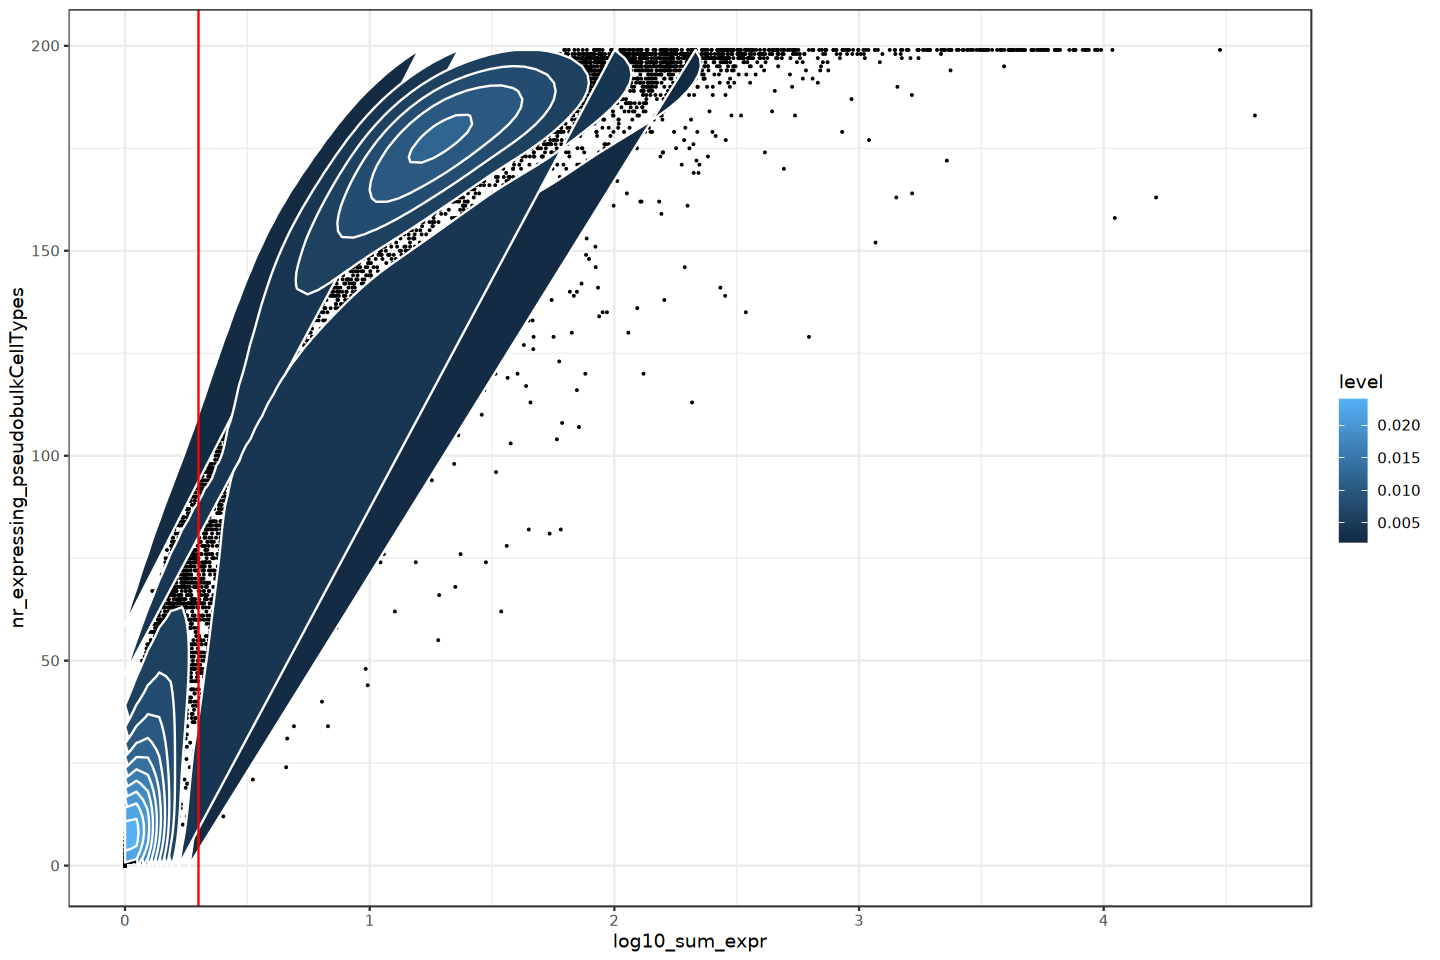

In [60]:
# plot sum expression vs nr expressing pseudobulk cell types
df <- data.frame(log10_sum_expr = log10(rowSums(as.matrix(counts_raw_pseudobulkCellType)) +1)
                 ,nr_expressing_pseudobulkCellTypes = nr_expressing_cell_types
                 ,passed_gene_filter = anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter
)

ggplot(data = df
             ,aes(x = log10_sum_expr
                  ,y = nr_expressing_pseudobulkCellTypes
             )
) +
        geom_point(size = 0.05)+
        stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
        geom_vline(xintercept = log10(threshold_sum_pseudobulkCellType_expr+1), color = "red")+
        theme_bw()

### filter genes

In [61]:
# filter genes by gene filter from the gene annotation file
counts_cf_ctf_gf <- counts_cf_ctf[anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter,]
print(dim(counts_cf_ctf_gf))

[1] 12485 74956


In [62]:
# filter gene annotation by gene filter from the gene annotation file
anno_genes_cf_ctf_gf <- anno_genes_cf_ctf[anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter,]

In [63]:
# store total counts per cell after gene filtering in the cell annotation file
anno_cells_cf_ctf_gf <- anno_cells_cf_ctf
anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf <- colSums(counts_cf_ctf_gf)

In [64]:
# store total counts per sample after gene filtering in the sample annotation file
anno_samples_cf_ctf_gf <- anno_samples_cf_ctf
anno_samples_cf_ctf_gf$total_counts_raw_cf_ctf_gf <- sapply(anno_samples_cf_ctf_gf$sample_ID
                                                         ,function(sample){
                                                                 idx_sample <- anno_cells_cf_ctf_gf$sample_ID == sample
                                                                 sum(anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf[idx_sample])
                                                         })

In [65]:
# store number of cell types per sample after gene filtering in the sample annotation file
anno_samples_cf_ctf_gf$nr_celltypes_cf_ctf_gf <- sapply(anno_samples_cf_ctf_gf$sample_ID
                                                         ,function(sample){
                                                                 idx_sample <- anno_cells_cf_ctf_gf$sample_ID == sample
                                                                 length(unique(anno_cells_cf_ctf_gf$cell_type[idx_sample]))
                                                         })

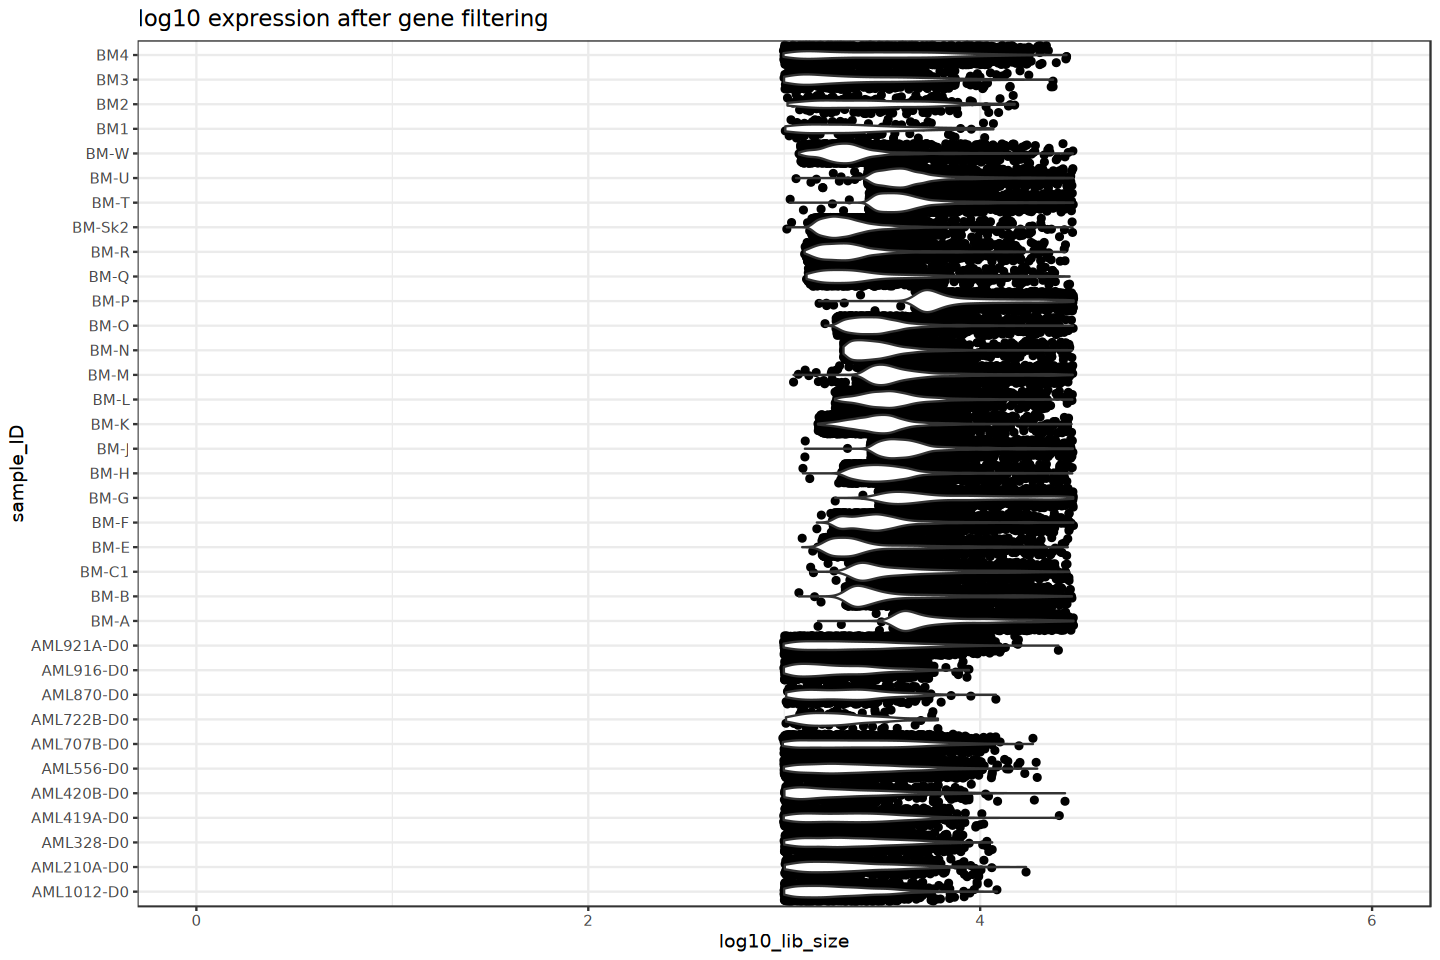

In [66]:
# visualize the expression after gene filter
df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf +1)
                 ,sample_ID = anno_cells_cf_ctf_gf$sample_ID
)

ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after gene filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

### export

In [67]:
# #save counts_cf_ctf_gf.RData
# save(counts_cf_ctf_gf, file = "counts_cf_ctf_gf.RData")

# #save anno_cells_cf_ctf_gf.RData
# save(anno_cells_cf_ctf_gf, file = "anno_cells_cf_ctf_gf.RData")

# #save anno_samples_cf_ctf_gf.RData
# save(anno_samples_cf_ctf_gf, file = "anno_samples_cf_ctf_gf.RData")
# 3
# #save anno_genes_cf_ctf_gf.RData
# save(anno_genes_cf_ctf_gf, file = "anno_genes_cf_ctf_gf.RData")

## Filter samples

Samples with less than 5 cell types will be filtered out.

- **INPUT:**
    - ```counts_cf_ctf_gf.RData``` 
    - ```anno_cells_cf_ctf_gf.RData```
    - ```anno_samples_cf_ctf_gf.RData```
    - ```anno_genes_cf_ctf_gf.RData```
    
- **NOTES:**

    The '_sf' ending in the file names stands for sample filter.
    
- **OUTPUT:**

    -  ```counts_cf_ctf_gf_sf.RData``` 
    -  ```anno_cells_cf_ctf_gf_sf.RData``` 
    -  ```anno_samples_cf_ctf_gf_sf.RData```
    -  ```anno_genes_cf_ctf_gf_sf.RData```

In [68]:
# shape scheme for sample IDs
shape_sample <- c(1:11,1:24)
names(shape_sample) <- unique(anno_samples_cf_ctf_gf$sample_ID)

In [69]:
# size scheme for sample IDs
size_sample <- c(rep(2,11),rep(1,24))
names(size_sample) <- unique(anno_samples_cf_ctf_gf$sample_ID)

In [70]:
# thresholds ####
threshold_nr_celltypes <- 5
print(paste("A sample should contain at least"
            ,threshold_nr_celltypes
            ,"cell types"))

[1] "A sample should contain at least 5 cell types"


### filter

In [71]:
anno_samples_cf_ctf_gf$threshold_nr_celltypes <- paste("greater or equal"
                                              ,threshold_nr_celltypes)
anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes <- anno_samples_cf_ctf_gf$nr_celltypes_cf_ctf_gf >= threshold_nr_celltypes


In [72]:
print(paste("we have"
            ,sum(anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes)
            ,"samples that passed the threshold"))
print(paste("we have"
            ,sum(!anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes)
            ,"samples that didn't pass the threshold:"))

[1] "we have 33 samples that passed the threshold"
[1] "we have 2 samples that didn't pass the threshold:"


In [73]:
bad_samples <- anno_samples_cf_ctf_gf$sample_ID[!anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes]
print(bad_samples)

[1] "AML722B-D0" "AML870-D0" 


### visualization

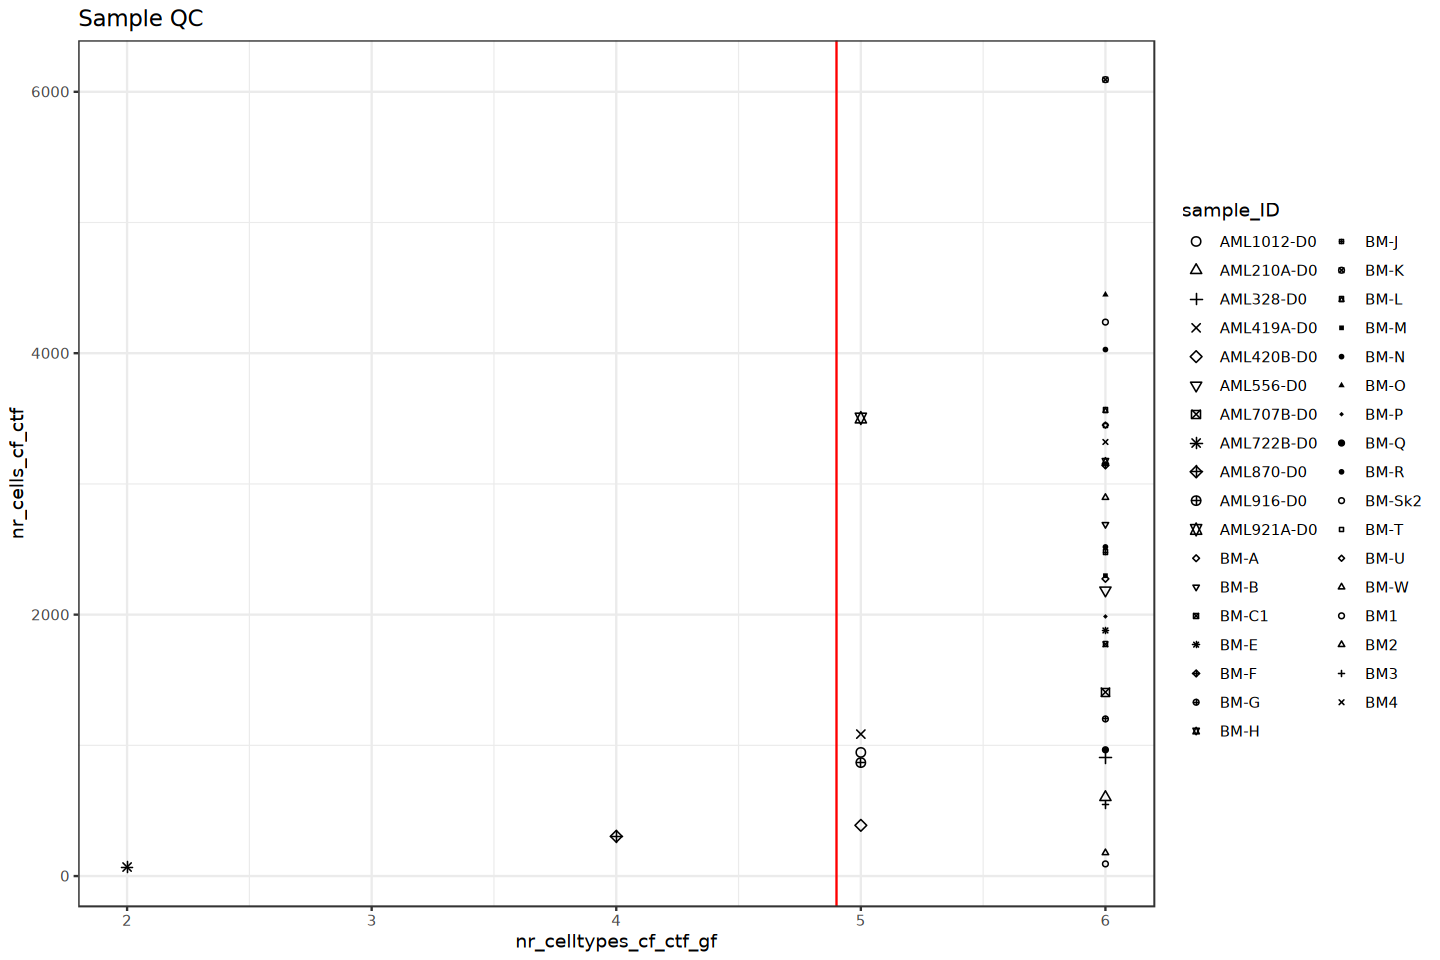

In [74]:
ggplot(data = anno_samples_cf_ctf_gf
       ,aes(x = nr_celltypes_cf_ctf_gf
            ,y = nr_cells_cf_ctf
            #,color = sample_ID
            ,shape = sample_ID
            ,size = sample_ID
       )
) +
        geom_point()+
        ggtitle("Sample QC") +
        geom_vline(xintercept = threshold_nr_celltypes- 0.1
                   ,color = "red")+
        scale_shape_manual(values=shape_sample)+
        scale_size_manual(values=size_sample)+
        theme_bw()

In [75]:
#subset anno_anno_samples_cf_ctf_gf

print("dim(anno_samples_cf_ctf_gf) before filtering")
print(dim(anno_samples_cf_ctf_gf))
anno_samples_cf_ctf_gf_sf <- anno_samples_cf_ctf_gf[anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes,]
print("dim(anno_samples_cf_ctf_gf_sf) after filtering")
print(dim(anno_samples_cf_ctf_gf_sf))

[1] "dim(anno_samples_cf_ctf_gf) before filtering"
[1] 35 15
[1] "dim(anno_samples_cf_ctf_gf_sf) after filtering"
[1] 33 15


In [76]:
#subset anno_cells

print("dim(anno_cells_cf_ctf_gf) before filtering")
print(dim(anno_cells_cf_ctf_gf))
idx_bad <- anno_cells_cf_ctf_gf$sample_ID %in% bad_samples
anno_cells_cf_ctf_gf_sf <- anno_cells_cf_ctf_gf[!idx_bad,]
print("dim(anno_cells_cf_ctf_gf_sf) after filtering")
print(dim(anno_cells_cf_ctf_gf_sf))

[1] "dim(anno_cells_cf_ctf_gf) before filtering"
[1] 74956    32
[1] "dim(anno_cells_cf_ctf_gf_sf) after filtering"
[1] 74583    32


In [77]:
#subset counts_cf_ctf_gf

print("dim(counts_cf_ctf_gf) before filtering")
print(dim(counts_cf_ctf_gf))
counts_cf_ctf_gf_sf <- counts_cf_ctf_gf[,!idx_bad]
print("dim(counts_cf_ctf_gf_sf) after filtering")
print(dim(counts_cf_ctf_gf_sf))

[1] "dim(counts_cf_ctf_gf) before filtering"
[1] 12485 74956
[1] "dim(counts_cf_ctf_gf_sf) after filtering"
[1] 12485 74583


In [78]:
anno_cells_cf_ctf_gf_sf$total_counts_raw_cf_ctf_gf_sf <- colSums(counts_cf_ctf_gf_sf)

anno_genes_cf_ctf_gf_sf <- anno_genes_cf_ctf_gf

In [79]:
# visualize expression after sample filter

df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf_gf_sf$total_counts_raw_cf_ctf_gf_sf +1)
                 ,sample_ID = anno_cells_cf_ctf_gf_sf$sample_ID
)
print(str(df))

'data.frame':	74583 obs. of  2 variables:
 $ log10_lib_size: num  3.11 3.63 3.22 3.31 3.15 ...
 $ sample_ID     : chr  "AML1012-D0" "AML1012-D0" "AML1012-D0" "AML1012-D0" ...
NULL


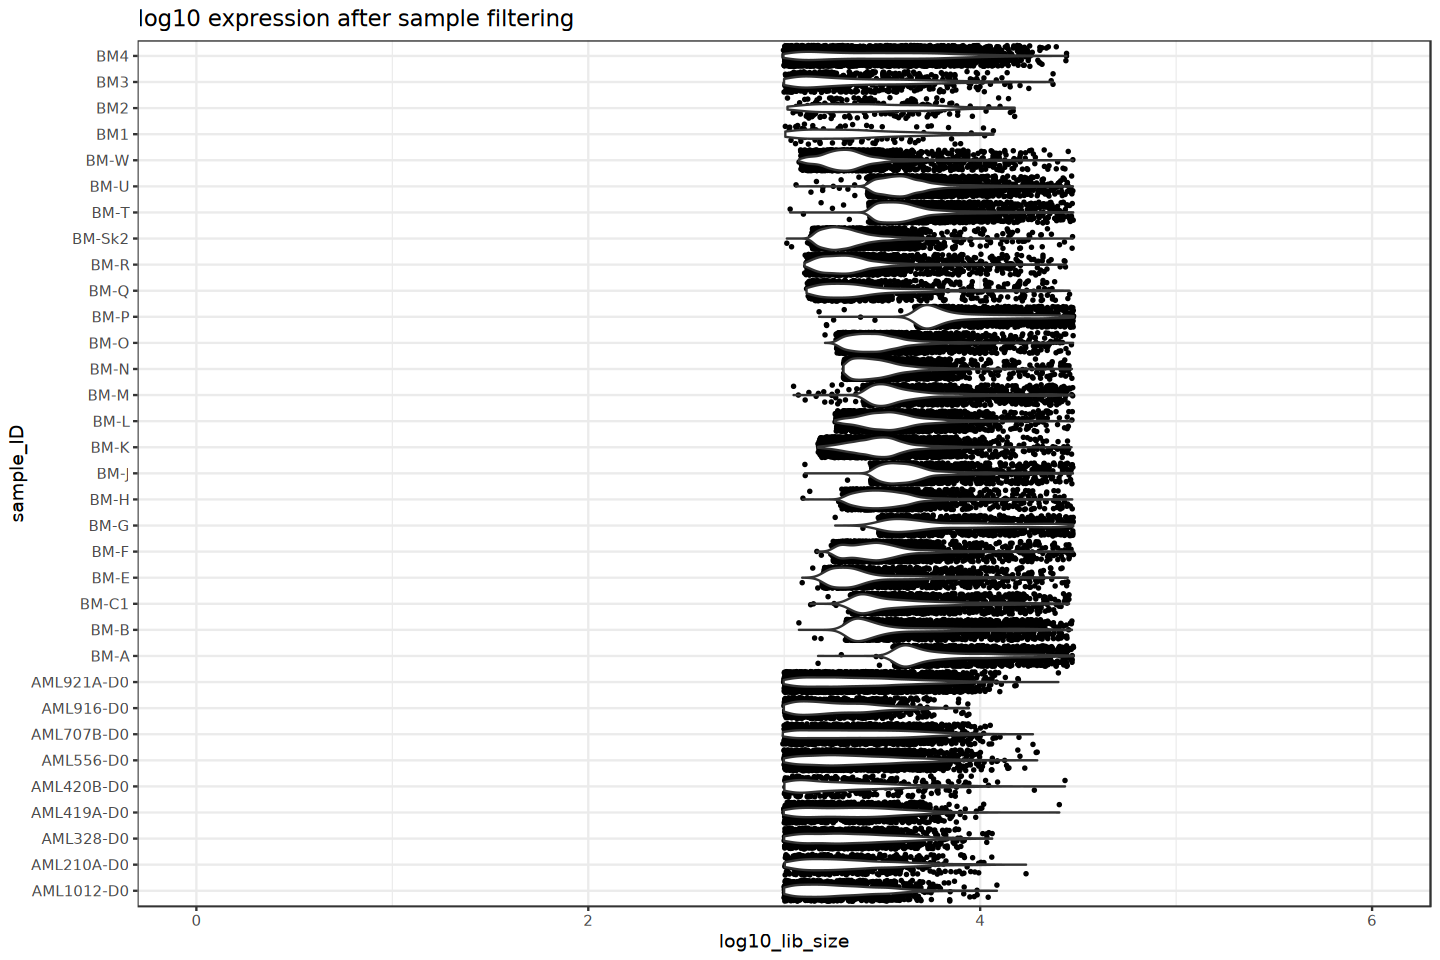

In [80]:
ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL
                    ,size = 0.5) +
        geom_violin() + 
        ggtitle("log10 expression after sample filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

### heatmap

In [81]:
#visualize cell number per cell type per sample

df <- table(data.frame(sample_ID = anno_cells_cf_ctf_gf_sf$sample_ID
                       ,cell_type = anno_cells_cf_ctf_gf_sf$cell_type)
            )
df <- t(matrix(df
               ,ncol = ncol(df)
               ,dimnames=dimnames(df)
               )
        )

In [82]:
# install.packages("circlize")

In [83]:
library("circlize")

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [84]:
library("ComplexHeatmap")

Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [86]:
col_fun = colorRamp2(c(0
                       ,10
                       #,50
                       ,100
                       ,1000
                       , max(df)), c("white"
                                     #,"lightgoldenrod1"
                                     #,"gold"
                                     ,"#CFCFCF"
                                     ,"#BFBFBF"
                                     #,"#A1A1A1"
                                     ,"salmon"
                                     , "darkred"))

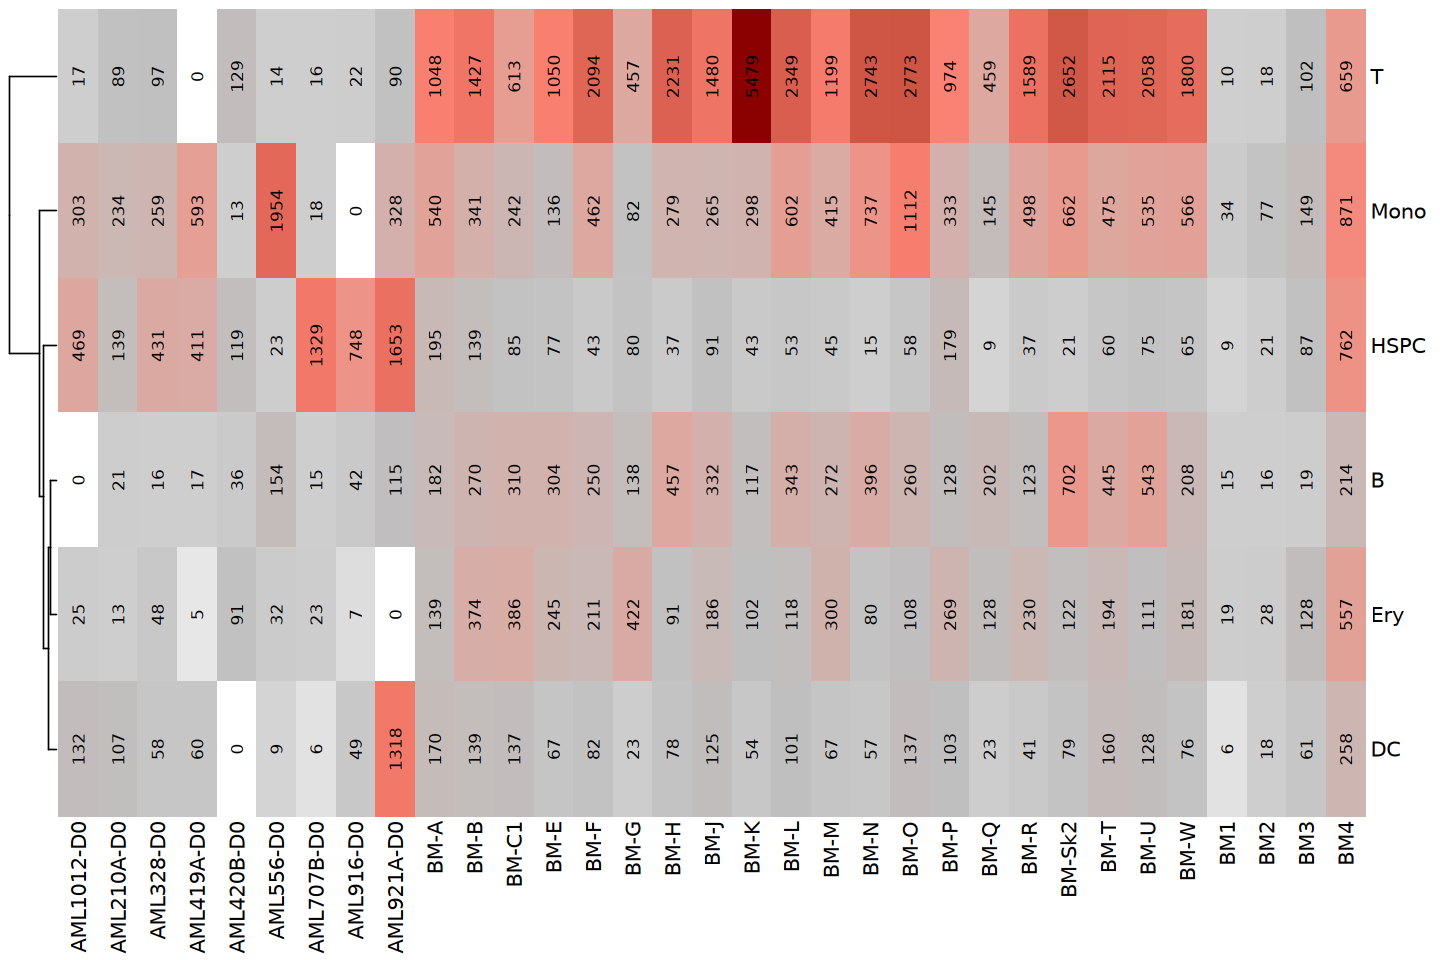

In [87]:
Heatmap(df
        ,cluster_columns = FALSE
        ,col = col_fun
        ,name="nr cells"
        ,show_heatmap_legend = FALSE
        ,cell_fun = function(j, i, x, y, width, height, fill) {
                grid.text(as.character(df[i, j])#sprintf("%.1f", df[i, j])
                          , x
                          , y
                          , gp = gpar(fontsize = 10
                                      )
                          ,rot=90
                          )
                }
        )

### export

In [89]:
#save counts_cf_ctf_gf_sf.RData
save(counts_cf_ctf_gf_sf, file = paste0(path_out, "counts_cf_ctf_gf_sf.RData"))

#save anno_cells_cf_ctf_gf_sf.RData
save(anno_cells_cf_ctf_gf_sf, file = paste0(path_out, "anno_cells_cf_ctf_gf_sf.RData"))

#save anno_samples_cf_ctf_gf_sf.RData
save(anno_samples_cf_ctf_gf_sf, file = paste0(path_out, "anno_samples_cf_ctf_gf_sf.RData"))

#save anno_genes_cf_ctf_gf_sf.RData
save(anno_genes_cf_ctf_gf_sf, file = paste0(path_out, "anno_genes_cf_ctf_gf_sf.RData"))